In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from resources import load_data, custom_k_fold_split, standardize_data
from tqdm import tqdm

def custom_F1_weighted(y_test, predictions):
    return f1_score(y_test, predictions, average='weighted', zero_division=0)

def custom_mean_squared_error(y_test, predictions):
    return np.mean((y_test-predictions)**2)

def fit_and_evaluate_model(model, X, y, metric: list[callable] = custom_F1_weighted, random_state=100):
    metric_list = [[] for _ in range(len(metric))]
    for fold in custom_k_fold_split(X, y, method='individual', random_state=random_state):
        X_train, X_test, y_train, y_test = fold
        X_train, X_test = standardize_data(X_train, X_test)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        for i, cur_metric in enumerate(metric):
            metric_list[i].append(cur_metric(y_test, predictions))
    return metric_list

def custom_resample(num_iterations, n_samples):
    sets = []
    for i in range(num_iterations):
        df = pd.read_csv('data/HR_data.csv', index_col=0).reset_index(drop=True)
        df.sample(n_samples, replace=True).to_csv('data/HR_data_bootstrapped.csv', index=False)
        X, y = load_data('data/HR_data_bootstrapped.csv')
        sets.append((X, y))
    return sets

def repeat_dataset(num_iterations):
    sets = []
    for i in range(num_iterations):
        X, y = load_data('data/HR_data.csv')
        sets.append((X, y))
    return sets

def no_resample():
    X, y = load_data('data/HR_data.csv')
    return [(X, y)]

def bootstrap_evaluation(model, sets, metric: list[callable] = custom_F1_weighted):
    bootstrap_results = {
        'metric': [[] for _ in range(len(metric))]
    }

    for i, (X, y) in tqdm(enumerate(sets), desc=str(model).split('.')[-1].split("\'")[0], total=len(sets)):
        model_ = model()
        ## random_state is set to 100 + i to ensure different random states for each iteration
        metric_ = fit_and_evaluate_model(model_, X, y, metric=metric, random_state=100 + i) 
        for i, cur_metric in enumerate(metric_):
            bootstrap_results['metric'][i].append(cur_metric)

    list_of_metrics = [[] for _ in range(len(metric))]
    for i, cur_metric in enumerate(bootstrap_results['metric']):           
        for round in cur_metric:
            for val in round:
                list_of_metrics[i].append(val)
    return list_of_metrics

In [2]:
from models import Baseline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

_METRIC_ = custom_mean_squared_error
_METRIC_NAME_ = 'MSE'

_METRIC2_ = custom_F1_weighted
_METRIC2_NAME_ = 'F1'

metric_list = [_METRIC_, _METRIC2_]

# data = custom_resample(20, 1000)
data = repeat_dataset(100)

acc, rff1 = bootstrap_evaluation(RandomForestClassifier, data, metric=metric_list)
nb_acc, nbf1 = bootstrap_evaluation(GaussianNB, data, metric=metric_list)
svc_acc, svcf1 = bootstrap_evaluation(SVC, data, metric=metric_list)
nn_acc, nnf1 = bootstrap_evaluation(lambda: MLPClassifier(max_iter=1000), data, metric=metric_list)
base_acc, basef1 = bootstrap_evaluation(Baseline, data, metric=metric_list)
models = ['Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline']
metrics = [acc, nb_acc, svc_acc, nn_acc, base_acc]
f1_list = [rff1, nbf1, svcf1, nnf1, basef1]
metric_iterators = zip(models, metrics, f1_list)

print('Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline')
print(np.mean(acc), np.mean(nb_acc), np.mean(svc_acc), np.mean(nn_acc), np.mean(base_acc))
print(np.mean(rff1), np.mean(nbf1), np.mean(svcf1), np.mean(nnf1), np.mean(basef1))

import pickle
for model, metric in zip(models, metrics):
    with open(f'metrics/{model}.pkl', 'wb') as f:
        pickle.dump(metric, f)

Baseline: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

Random Forest Naive Bayes SVC MLP Baseline
4.209523809523809 7.208333333333334 4.6190476190476195 4.224404761904761 5.351190476190477
0.18727976719048148 0.14988050970193828 0.14529306672163814 0.17461193568336425 0.14482422339565199


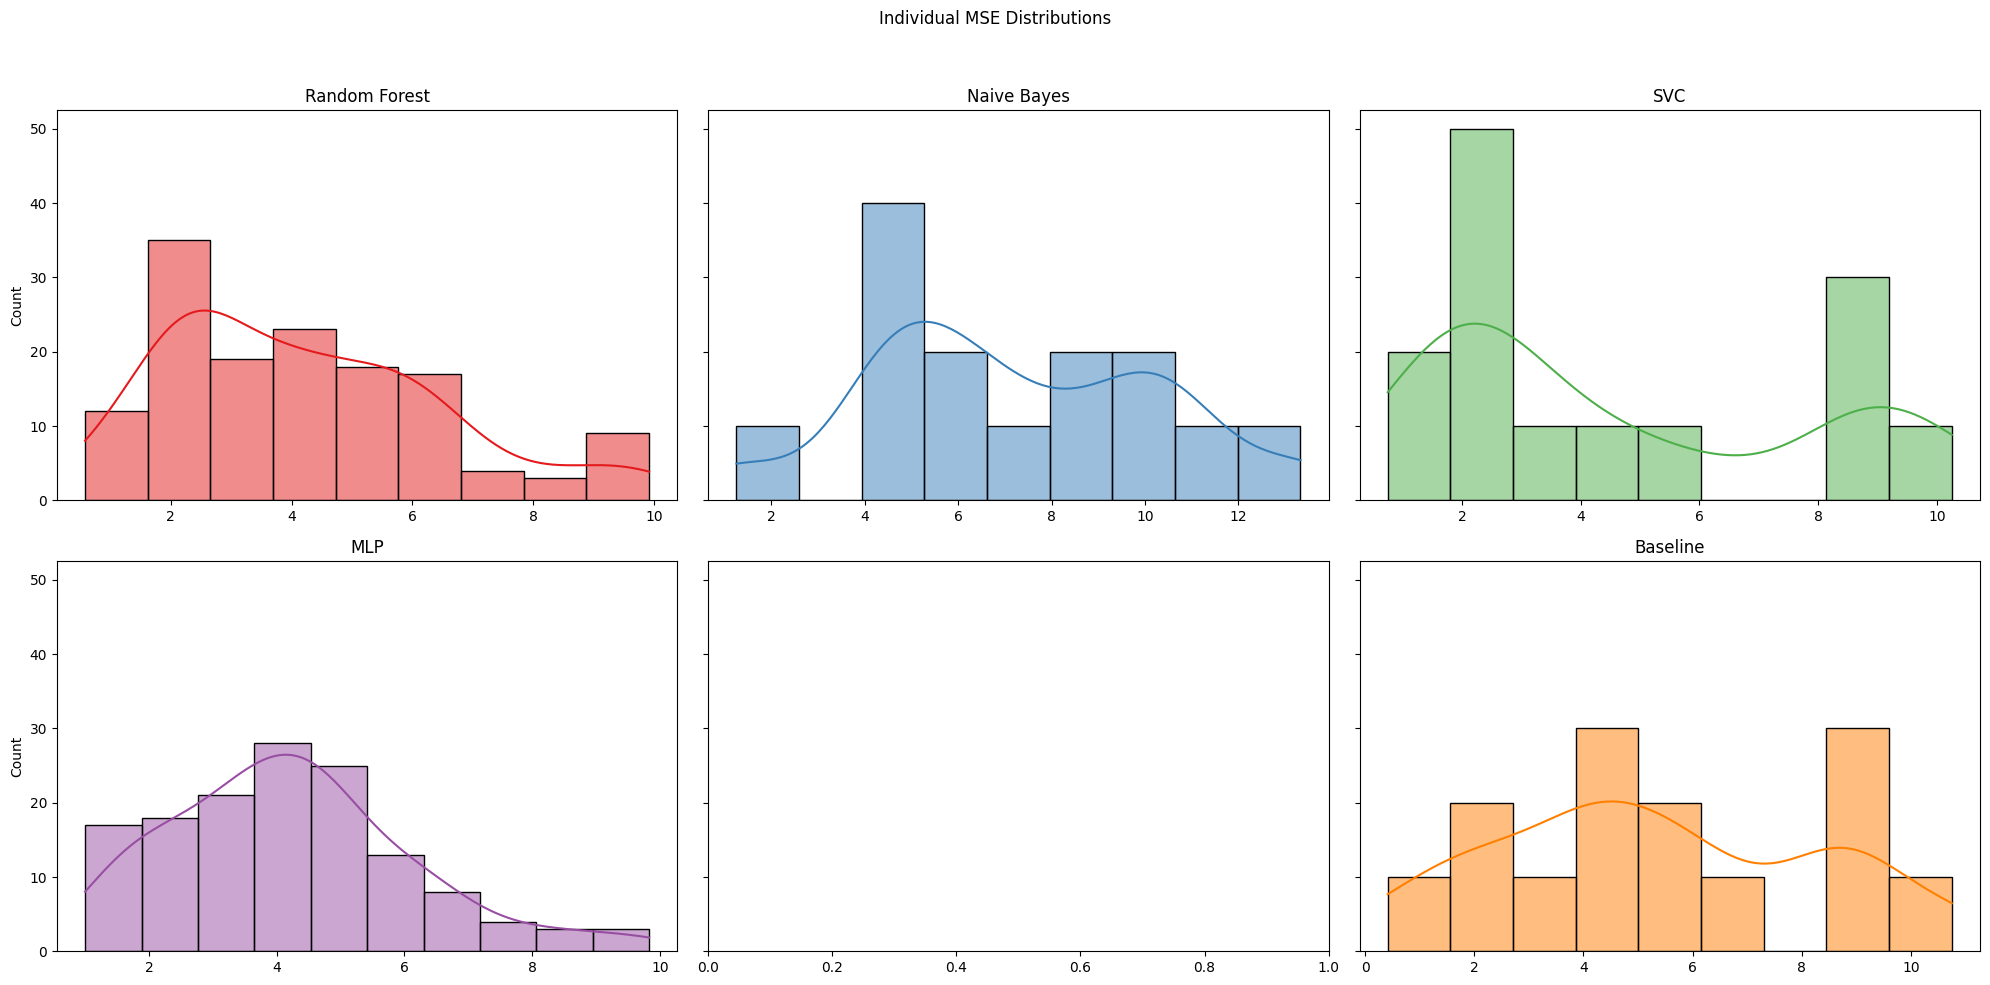

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'models', 'metrics', and '_METRIC_NAME_' are defined
colors = sns.color_palette('Set1', n_colors=5)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)

for i, (model, metric, color, ax) in enumerate(zip(models, metrics, colors, axs.flatten())):
    if i == 4: ax = axs.flatten()[i+1]
    sns.histplot(metric, color=color, kde=True, label=model, ax=ax)
    ax.set_title(model)  # Set title for each subplot

# Set a main title for the figure
fig.suptitle(f'Individual {_METRIC_NAME_} Distributions')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the main title

# Save the figure
plt.savefig(f'plots/individual_{_METRIC_NAME_}_dists.png')
plt.show()

Random Forest - Shapiro-Wilk Test Statistic: 0.9437044429380811
Random Forest - Shapiro-Wilk Test p-value: 1.959068466596285e-05
Random Forest - The data is not normally distributed (reject H0)
Naive Bayes - Shapiro-Wilk Test Statistic: 0.9495132585502185
Naive Bayes - Shapiro-Wilk Test p-value: 5.525983642771193e-05
Naive Bayes - The data is not normally distributed (reject H0)
SVC - Shapiro-Wilk Test Statistic: 0.8498642038642652
SVC - Shapiro-Wilk Test p-value: 1.24162233460806e-10
SVC - The data is not normally distributed (reject H0)
MLP - Shapiro-Wilk Test Statistic: 0.9632984563608274
MLP - Shapiro-Wilk Test p-value: 0.0008278163900335616
MLP - The data is not normally distributed (reject H0)
Baseline - Shapiro-Wilk Test Statistic: 0.9442744399264362
Baseline - Shapiro-Wilk Test p-value: 2.1636922429341658e-05
Baseline - The data is not normally distributed (reject H0)


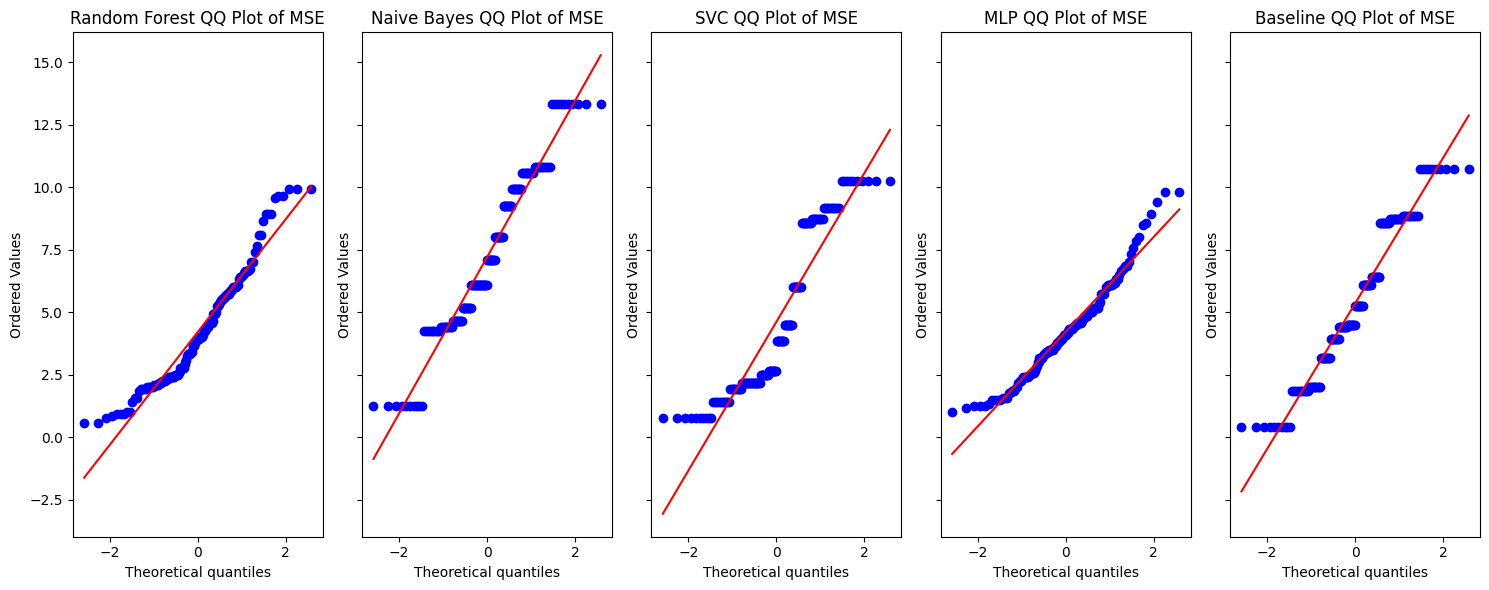

,Model,MSE Shapiro-Wilk Test p-value,F1 Shapiro-Wilk Test p-value
0,Random Forest,1.959068e-05,3.071466e-06
1,Naive Bayes,5.525984e-05,2.339348e-10
2,SVC,1.241622e-10,1.981893e-10
3,MLP,8.278164e-04,1.173537e-04
4,Baseline,2.163692e-05,1.829439e-17


In [4]:
from scipy import stats

shapiro_results = []

# Assuming 'models', 'metrics', and '_METRIC_NAME_' are defined
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(models), figsize=(15, 6), sharey=True)

for (model, metric, f1), ax in zip(metric_iterators, axs.flatten()):
    # QQ Plot in its own subplot
    stats.probplot(metric, dist="norm", plot=ax)
    ax.set_title(f"{model} QQ Plot of {_METRIC_NAME_}")

    # Shapiro-Wilk Test
    shapiro_test = stats.shapiro(metric)
    print(f"{model} - Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
    print(f"{model} - Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

    # Interpretation
    if shapiro_test.pvalue > 0.05:
        print(f"{model} - The data is normally distributed (fail to reject H0)")
    else:
        print(f"{model} - The data is not normally distributed (reject H0)")

    shapiro_results.append({
        'Model': model,
        f'{_METRIC_NAME_} Shapiro-Wilk Test p-value': shapiro_test.pvalue,
        f'{_METRIC2_NAME_} Shapiro-Wilk Test p-value': stats.shapiro(f1).pvalue if f1 else 'N/A'
    })

# Adjust layout
plt.tight_layout()
plt.savefig('plots/qqplots.png')
plt.show()

# Convert results to DataFrame and save
shapiro_df = pd.DataFrame(shapiro_results)
with open('tables/shapiro.txt', 'w') as f:
    f.write(shapiro_df.to_latex())

shapiro_df

In [5]:
from scipy.stats import kruskal

# Example accuracies from three models


# Kruskal-Wallis H Test
kruskal_test = kruskal(*metrics)
print(f"{_METRIC_NAME_} Kruskal-Wallis H Test Statistic:", kruskal_test.statistic)
print(f"{_METRIC_NAME_} Kruskal-Wallis H Test p-value:", kruskal_test.pvalue)

print('\n')

kruskal_test_f1 = kruskal(*f1_list)
print(f"{_METRIC2_NAME_} Kruskal-Wallis H Test Statistic:", kruskal_test_f1.statistic)
print(f"{_METRIC2_NAME_} Kruskal-Wallis H Test p-value:", kruskal_test_f1.pvalue)

# Interpretation
if kruskal_test.pvalue > 0.05:
    print("No significant difference between the models (fail to reject H0)")
else:
    print("Significant difference between the models (reject H0)")


MSE Kruskal-Wallis H Test Statistic: 89.79060003923676
MSE Kruskal-Wallis H Test p-value: 1.4587711015442657e-18


F1 Kruskal-Wallis H Test Statistic: 24.586032554989515
F1 Kruskal-Wallis H Test p-value: 6.0930452200381084e-05
Significant difference between the models (reject H0)


In [6]:
from scipy.stats import wilcoxon

p_val_matrix = np.zeros((5, 5))

for model, metric in zip(models, metrics):

    for model2, metric2 in zip(models, metrics):
        if model == model2:
            continue

        print(f"Comparing {model} and {model2}")

        # Wilcoxon Signed-Rank Test
        wilcoxon_test = wilcoxon(metric, metric2)
        print("Wilcoxon Test Statistic:", wilcoxon_test.statistic)
        print("Wilcoxon Test p-value:", wilcoxon_test.pvalue)

        print('\n')

        wilcoxon_test_f1 = wilcoxon(f1_list[models.index(model)], f1_list[models.index(model2)])
        print("F1 Wilcoxon Test Statistic:", wilcoxon_test_f1.statistic)
        print("F1 Wilcoxon Test p-value:", wilcoxon_test_f1.pvalue)

        print('\n')

        # Interpretation
        if wilcoxon_test.pvalue > 0.05:
            print(f"No significant difference between the {_METRIC_NAME_} of the two models (fail to reject H0)")
        else:
            print(f"Significant difference between the {_METRIC_NAME_} of the two models (reject H0)")
        print('\n')
        p_val_matrix[models.index(model), models.index(model2)] = wilcoxon_test.pvalue


Comparing Random Forest and Naive Bayes
Wilcoxon Test Statistic: 1538.0
Wilcoxon Test p-value: 1.5900576463335452e-12


F1 Wilcoxon Test Statistic: 3877.0
F1 Wilcoxon Test p-value: 0.03776947474477382


Significant difference between the MSE of the two models (reject H0)


Comparing Random Forest and SVC
Wilcoxon Test Statistic: 4371.5
Wilcoxon Test p-value: 0.29940587041165845


F1 Wilcoxon Test Statistic: 3385.0
F1 Wilcoxon Test p-value: 0.0018589240667704408


No significant difference between the MSE of the two models (fail to reject H0)


Comparing Random Forest and MLP
Wilcoxon Test Statistic: 4442.0
Wilcoxon Test p-value: 0.5410142750230099


F1 Wilcoxon Test Statistic: 4664.5
F1 Wilcoxon Test p-value: 0.6733509403531601


No significant difference between the MSE of the two models (fail to reject H0)


Comparing Random Forest and Baseline
Wilcoxon Test Statistic: 2243.5
Wilcoxon Test p-value: 6.763842447974192e-07


F1 Wilcoxon Test Statistic: 2669.0
F1 Wilcoxon Test p-value: 1

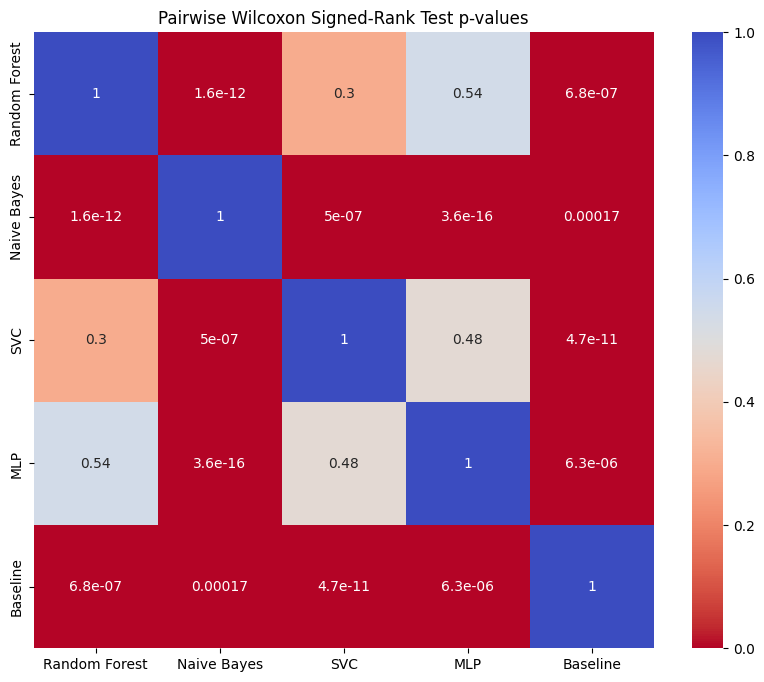

In [7]:
# Initialize p-value matrix
p_val_matrix = np.ones((len(models), len(models))) 

# Compute pairwise Wilcoxon Signed-Rank Test
for i, metric in enumerate(metrics):
    for j, metric2 in enumerate(metrics):
        if i == j:
            continue
        wilcoxon_test = wilcoxon(metric, metric2)
        p_val_matrix[i, j] = wilcoxon_test.pvalue

# Visualize p-value matrix with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_val_matrix, xticklabels=models, yticklabels=models, annot=True, cmap='coolwarm_r', cbar=True)
plt.title('Pairwise Wilcoxon Signed-Rank Test p-values')
plt.savefig('plots/pairwise_wilcoxon_pvalues.png')
plt.show()

In [8]:
mean_metrics = [np.mean(m) for m in metrics]
std_metrics = [np.std(m) for m in metrics]

f1_mean_metrics = [np.mean(m) for m in f1_list]
f1_std_metrics = [np.std(m) for m in f1_list]

df = pd.DataFrame(
    np.array(
        [mean_metrics, std_metrics, f1_mean_metrics, f1_std_metrics]).T, index=models, columns=[f'Mean {_METRIC_NAME_ }', 
                                                               f'{_METRIC_NAME_} Standard Deviation',
                                                               f'Mean {_METRIC2_NAME_}',
                                                               f'{_METRIC2_NAME_} Standard Deviation']
    )
df

,Mean MSE,MSE Standard Deviation,Mean F1,F1 Standard Deviation
Random Forest,4.209524,2.286119,0.187280,0.133028
Naive Bayes,7.208333,3.155486,0.149881,0.147049
SVC,4.619048,3.168658,0.145293,0.132876
MLP,4.224405,1.901281,0.174612,0.123088
Baseline,5.351190,2.943950,0.144824,0.188260


Model: Random Forest
MSE 95% Confidence Interval: [3.837, 4.597]
F1 95% Confidence Interval: [0.165, 0.209]


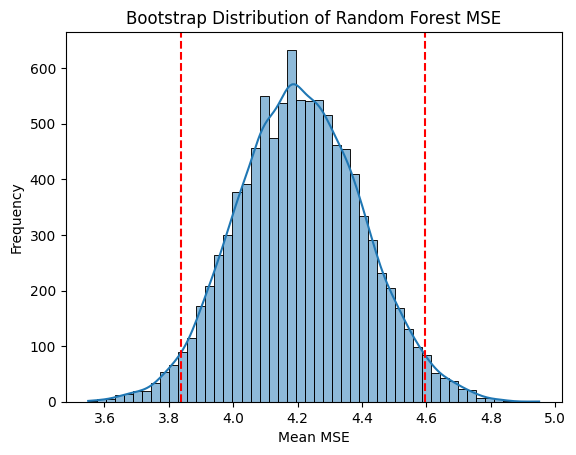

C:\Users\pvest\AppData\Local\Temp\ipykernel_1852\71786458.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ci_df = pd.concat([ci_df, confidence_intervals])


Model: Naive Bayes
MSE 95% Confidence Interval: [6.679, 7.739]
F1 95% Confidence Interval: [0.126, 0.175]


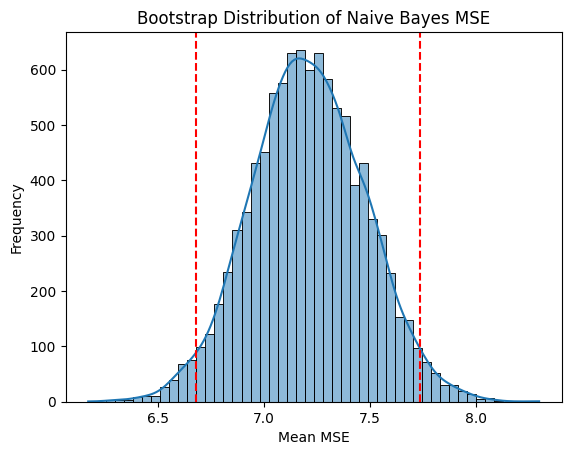

Model: SVC
MSE 95% Confidence Interval: [4.101, 5.164]
F1 95% Confidence Interval: [0.124, 0.168]


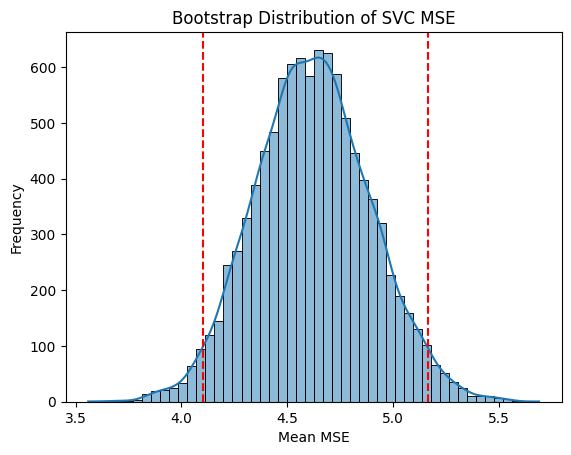

Model: MLP
MSE 95% Confidence Interval: [3.907, 4.539]
F1 95% Confidence Interval: [0.155, 0.195]


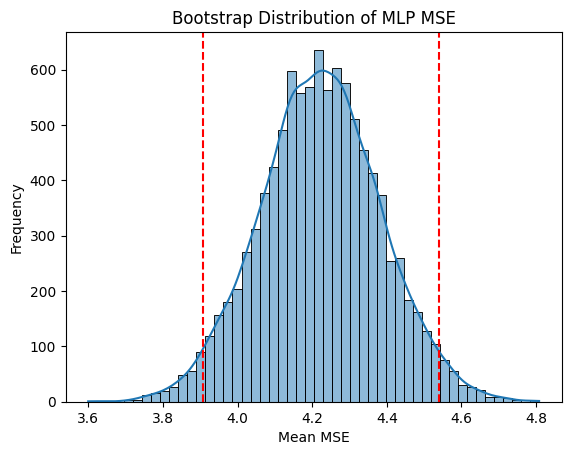

Model: Baseline
MSE 95% Confidence Interval: [4.863, 5.840]
F1 95% Confidence Interval: [0.115, 0.178]


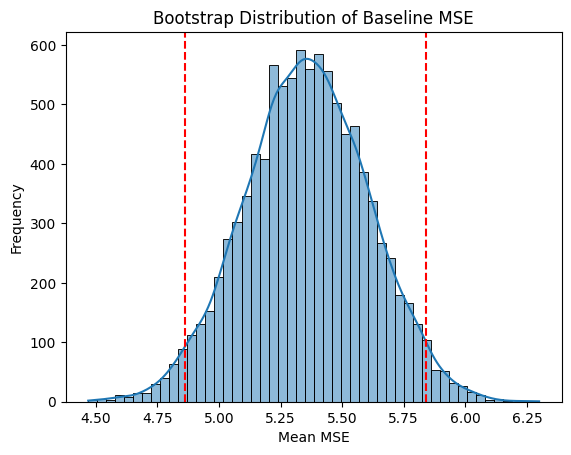

,MSE Lower Bound,MSE Upper Bound,MSE Mean,MSE Standard Deviation,F1 Lower Bound,F1 Upper Bound,F1 Mean,F1 Standard Deviation
Model,,,,,,,,
Random Forest,3.836890,4.597024,4.209524,2.286119,0.165350,0.209281,0.187280,0.133028
MLP,3.907128,4.539286,4.224405,1.901281,0.154579,0.195176,0.174612,0.123088
SVC,4.100595,5.163705,4.619048,3.168658,0.123676,0.167734,0.145293,0.132876
Baseline,4.863080,5.839881,5.351190,2.943950,0.115018,0.177608,0.144824,0.188260
Naive Bayes,6.678557,7.738735,7.208333,3.155486,0.125907,0.174692,0.149881,0.147049


In [9]:
ci_df = pd.DataFrame(columns=['Model', f'{_METRIC_NAME_} Lower Bound', f'{_METRIC_NAME_} Upper Bound', f'{_METRIC_NAME_} Mean', f'{_METRIC_NAME_} Standard Deviation',
                              'F1 Lower Bound', 'F1 Upper Bound', 'F1 Mean', 'F1 Standard Deviation'])
for model, metric, f1 in zip(models, metrics, f1_list):
    ## Number of bootstrap samples
    n_bootstraps = 10_000
    bootstrapped_accuracies = []
    bootstrapped_f1_scores = []

    # Perform bootstrap sampling for metric
    for _ in range(n_bootstraps):
        bootstrapped_sample_metric = np.random.choice(metric, size=len(metric), replace=True)
        bootstrapped_accuracies.append(np.mean(bootstrapped_sample_metric))

    # Perform bootstrap sampling for f1
    for _ in range(n_bootstraps):
        bootstrapped_sample_f1 = np.random.choice(f1, size=len(f1), replace=True)
        bootstrapped_f1_scores.append(np.mean(bootstrapped_sample_f1))

    # Calculate confidence intervals for metric
    alpha = 0.95
    lower_bound_metric = np.percentile(bootstrapped_accuracies, (1 - alpha) / 2 * 100)
    upper_bound_metric = np.percentile(bootstrapped_accuracies, (1 + alpha) / 2 * 100)

    # Calculate confidence intervals for f1
    lower_bound_f1 = np.percentile(bootstrapped_f1_scores, (1 - alpha) / 2 * 100)
    upper_bound_f1 = np.percentile(bootstrapped_f1_scores, (1 + alpha) / 2 * 100)

    # Print confidence intervals for metric
    print(f"Model: {model}")
    print(f"{_METRIC_NAME_} 95% Confidence Interval: [{lower_bound_metric:.3f}, {upper_bound_metric:.3f}]")
    # Print confidence intervals for f1
    print(f"F1 95% Confidence Interval: [{lower_bound_f1:.3f}, {upper_bound_f1:.3f}]")

    # Visualization of the bootstrap distribution and confidence interval for metric
    sns.histplot(bootstrapped_accuracies, bins=50, kde=True)
    plt.axvline(lower_bound_metric, color='red', linestyle='--')
    plt.axvline(upper_bound_metric, color='red', linestyle='--')
    plt.title(f'Bootstrap Distribution of {model} {_METRIC_NAME_}')
    plt.xlabel(f'Mean {_METRIC_NAME_}')
    plt.ylabel('Frequency')
    plt.savefig(f'plots/{model}_bootstrap_ci.png')
    plt.show()

    # Add confidence intervals to the DataFrame
    confidence_intervals = pd.DataFrame({
        'Model': [model],
        f'{_METRIC_NAME_} Lower Bound': [lower_bound_metric],
        f'{_METRIC_NAME_} Upper Bound': [upper_bound_metric],
        f'{_METRIC_NAME_} Mean': [np.mean(metric)],
        f'{_METRIC_NAME_} Standard Deviation': [np.std(metric)],
        'F1 Lower Bound': [lower_bound_f1],
        'F1 Upper Bound': [upper_bound_f1],
        'F1 Mean': [np.mean(f1)],
        'F1 Standard Deviation': [np.std(f1)]
    })

    ci_df = pd.concat([ci_df, confidence_intervals])



ci_df = ci_df.set_index('Model')

ci_df = ci_df.sort_values(by=f'{_METRIC_NAME_} Mean', ascending=True)
with open('tables/conf_int.txt', 'w') as f:
    f.write(ci_df.to_latex())
ci_df